In [1]:
import warnings
warnings.filterwarnings('ignore')

# Import the dependencies
import os
from collections import Counter
from dotenv import load_dotenv
from pymongo import MongoClient
import pandas as pd
import numpy as np
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN, HDBSCAN, KMeans
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from sklearn.decomposition import PCA

import holoviews as hv
import hvplot.pandas
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import seaborn as sns
import sweetviz as sv

In [2]:
# load the config from the .env file
load_dotenv()
MONGODB_URI = os.environ['MONGODB_URI']

# Connect to the database engine
client = MongoClient(MONGODB_URI)

# connect to the project db
db = client['ExpectLifeRedux']

# get a reference to the data collection
data = db['SSS_Clustering_Data']

In [3]:
# Create a dataframe from the collection
SSS_df = pd.DataFrame(list(data.find()))

In [4]:
# Drop the database id data and refresh the index
SSS_df = SSS_df.drop(['_id'], axis=1)
SSS_df = SSS_df.reset_index(drop=True)

# Create a new DataFrame for the country names.  Apply the country names as the new index for later merging.
country_df = pd.DataFrame()
country_df['country'] = SSS_df['country']
country_df = country_df.set_index('country', drop=False)

# Set the DataFrame index to the country names to get them out of the way
SSS_df = SSS_df.set_index('country')
ori_df = SSS_df.copy()
SSS_df.head(5)

,sss_depth,system_type
country,,
Albania,2,"Universal medical benefits,Social insurance sy..."
Algeria,1,Social insurance system
Andorra,1,Social insurance system
Angola,3,"Universal medical benefits,Social insurance sy..."
Antigua and Barbuda,1,Social insurance system


In [5]:
#create a list of component phrases to match
component_terms = ["community-based social insurance","employer-liability system (cash benefits)","employer-liability system (cash maternity benefits)","employer-liability system (cash medical benefits)","employer-liability system (cash sickness benefits)","employer-liability system (maternity benefits)","employer-liability system (medical benefits)","employer-liability system (parental leave)","employer-liability system (paternity benefits)","employer-liability system (paternity leave)","employer-liability system (sickness benefits)","employer-liability system through private carriers","employer-liability system","employment-related system (cash benefits)","employment-related system (cash maternity benefits)","employment-related system (cash sickness benefits)","employment-related system (parental benefits)","employment-related system (tuberculosis benefits)","mandatory health insurance (medical benefits)","mandatory health insurance through private carriers (medical benefits)","mandatory individual account system (medical benefits)","mandatory private insurance (cash benefits)","mandatory private insurance (medical benefits)","mandatory private insurance","mandatory private pension scheme","open pension funds","provident fund (birth grant)","provident fund (medical benefits)","Retirement pension scheme","social assistance system (birth grant)","social assistance system (cash benefits)","social assistance system (cash birth grants)","social assistance system (cash maternity benefits)","social assistance system (cash sickness benefits)","social assistance system (funeral grant)","social assistance system (long-term care benefits)","social assistance system (maternity benefits)","social assistance system (medical benefits)","social assistance system (parental leave)","social assistance system","social insurance system (cash benefits)","social insurance system (cash maternity benefits)","social insurance system (cash medical benefits)","social insurance system (cash parental benefits)","social insurance system (cash sickness benefits)","social insurance system (cash sickness)","social insurance system (child care benefits)","social insurance system (in-kind benefits)","social insurance system (maternity benefits)","social insurance system (maternity medical benefits)","social insurance system (medical benefits)","social insurance system (prenatal benefits)","social insurance system","universal (adoption grant)","universal (birth grant)","universal (cash maternity benefits)","universal (cash parental grants)","universal (paid parental leave)","universal (parental benefits)","universal (pregnancy grant)","universal (prenatal care grant)","universal medical benefits","voluntary community-based social insurance system (medical benefits)","voluntary pension scheme"]

In [6]:
# Create a regex pattern from the list of components that will match across word boundaries
regex_pattern = r'(' + '|'.join(map(re.escape, sorted(component_terms, key=len, reverse=True))) + r')'

# Ensure the pattern is compiled for efficiency
compiled_pattern = re.compile(regex_pattern, flags=re.IGNORECASE)

# Function to match components using regex
def find_components(system_type, pattern):
    # Find all matches of the pattern within the system_type string
    matches = re.findall(pattern, system_type)
    return list(set(matches))  # return unique matches only

# Apply this function to the 'system_type' column
SSS_df['components_matched'] = SSS_df['system_type'].apply(lambda x: find_components(x, compiled_pattern))
SSS_df

,sss_depth,system_type,components_matched
country,,,
Albania,2,"Universal medical benefits,Social insurance sy...","[Universal medical benefits, Social insurance ..."
Algeria,1,Social insurance system,[Social insurance system]
Andorra,1,Social insurance system,[Social insurance system]
Angola,3,"Universal medical benefits,Social insurance sy...","[Universal medical benefits, Employer-liabilit..."
Antigua and Barbuda,1,Social insurance system,[Social insurance system]
...,...,...,...
Venezuela,2,"Universal medical benefits,Universal (birth gr...","[Universal medical benefits, Social insurance ..."
Vietnam,1,Social insurance system,[Social insurance system]
Yemen,2,"Universal medical benefits,Employer-liability ...","[Universal medical benefits, Employer-liabilit..."


In [7]:
# Since components won't repeat within a system type, using them as a single string per country makes sense
SSS_df['components_str'] = SSS_df['components_matched'].apply(' '.join)

# Define the stop words
stoppers = ['system','benefits','social','through']
# Apply the TfidfVectorizer to this column
tfidf_vectorizer = TfidfVectorizer(ngram_range=(3,3), stop_words=stoppers, max_features=75)
#, max_features=30
tfidf_matrix = tfidf_vectorizer.fit_transform(SSS_df['components_str'])

# Transform the TF-IDF matrix to a DataFrame for clustering
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out(), index=SSS_df.index)
tfidf_df.describe()

,assistance cash insurance,assistance cash maternity,assistance maternity insurance,assistance medical employer,assistance medical insurance,birth grant universal,cash employer liability,cash insurance cash,cash maternity assistance,cash maternity employer,...,sickness assistance cash,sickness employer liability,sickness insurance cash,sickness insurance medical,universal birth grant,universal medical assistance,universal medical employer,universal medical employment,universal medical insurance,universal medical universal
count,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,...,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,0.006381,0.003662,0.006059,0.017031,0.038102,0.004143,0.011066,0.007131,0.003662,0.018943,...,0.005888,0.022944,0.028149,0.005622,0.008536,0.030102,0.073937,0.010018,0.092996,0.006378
std,0.061381,0.035204,0.059598,0.096001,0.122368,0.040087,0.077536,0.057053,0.035204,0.080361,...,0.046701,0.095446,0.099896,0.054390,0.067516,0.141618,0.199524,0.068667,0.254446,0.062383
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.635459,0.360903,0.687154,0.796026,0.510872,0.433792,0.675911,0.514372,0.360903,0.450253,...,0.449819,0.506059,0.524559,0.588239,0.600457,1.000000,0.756922,0.577350,1.000000,0.707107


In [8]:
tfidf_df

,assistance cash insurance,assistance cash maternity,assistance maternity insurance,assistance medical employer,assistance medical insurance,birth grant universal,cash employer liability,cash insurance cash,cash maternity assistance,cash maternity employer,...,sickness assistance cash,sickness employer liability,sickness insurance cash,sickness insurance medical,universal birth grant,universal medical assistance,universal medical employer,universal medical employment,universal medical insurance,universal medical universal
country,,,,,,,,,,,,,,,,,,,,,
Albania,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.780444,0.0
Algeria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
Andorra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
Angola,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.452843,0.0,0.000000,0.0,0.382034,0.0,0.000000,0.0
Antigua and Barbuda,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Venezuela,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.600457,0.0,0.000000,0.0,0.378144,0.0
Vietnam,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
Yemen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.673827,0.0,0.000000,0.0


In [9]:
# Drop the text columns
SSS_df = SSS_df.drop(['system_type','components_matched','components_str'], axis=1)
SSS_df

,sss_depth
country,
Albania,2
Algeria,1
Andorra,1
Angola,3
Antigua and Barbuda,1
...,...
Venezuela,2
Vietnam,1
Yemen,2


In [10]:
# Concatenate with original df
SSS_df= pd.concat([SSS_df, tfidf_df], axis=1)
SSS_df

,sss_depth,assistance cash insurance,assistance cash maternity,assistance maternity insurance,assistance medical employer,assistance medical insurance,birth grant universal,cash employer liability,cash insurance cash,cash maternity assistance,...,sickness assistance cash,sickness employer liability,sickness insurance cash,sickness insurance medical,universal birth grant,universal medical assistance,universal medical employer,universal medical employment,universal medical insurance,universal medical universal
country,,,,,,,,,,,,,,,,,,,,,
Albania,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.780444,0.0
Algeria,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
Andorra,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
Angola,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.452843,0.0,0.000000,0.0,0.382034,0.0,0.000000,0.0
Antigua and Barbuda,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Venezuela,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.600457,0.0,0.000000,0.0,0.378144,0.0
Vietnam,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
Yemen,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.673827,0.0,0.000000,0.0


In [11]:
# Collect the column labels so they can be reapplied after data scaling
tfidf_col_names = SSS_df.columns.tolist()

In [12]:
# Standardize the data with MaxAbsScaler(). Using this scaler to maintain integrity of sparse encoded values.
scaler = MaxAbsScaler()

encode_scaled_nda = scaler.fit_transform(SSS_df)
encode_scaled_nda

array([[0.4       , 0.        , 0.        , ..., 0.        , 0.78044357,
        0.        ],
       [0.2       , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.2       , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.4       , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.4       , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.2       , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [13]:
# Convert the scaled-encoded data back to a DataFrame (nda = Numpy Data Array)
scale_encode_df = pd.DataFrame(encode_scaled_nda, index=SSS_df.index)

# Apply the column labels to ensure the data is properly identified
scale_encode_df = scale_encode_df.set_axis(tfidf_col_names, axis=1)
scale_encode_df

,sss_depth,assistance cash insurance,assistance cash maternity,assistance maternity insurance,assistance medical employer,assistance medical insurance,birth grant universal,cash employer liability,cash insurance cash,cash maternity assistance,...,sickness assistance cash,sickness employer liability,sickness insurance cash,sickness insurance medical,universal birth grant,universal medical assistance,universal medical employer,universal medical employment,universal medical insurance,universal medical universal
country,,,,,,,,,,,,,,,,,,,,,
Albania,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.780444,0.0
Algeria,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0
Andorra,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0
Angola,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.863283,0.0,0.0,0.0,0.50472,0.0,0.000000,0.0
Antigua and Barbuda,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Venezuela,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,1.0,0.0,0.00000,0.0,0.378144,0.0
Vietnam,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0
Yemen,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.89022,0.0,0.000000,0.0


In [14]:
# Create an elbow curve to find the best value for K.
inertia = []
k= list(range(1,15))

# Calculate the inertia for a range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(scale_encode_df)
    inertia.append(km.inertia_)
    
# Create the elbow curve
elbow_data = {'k': k, 'inertia': inertia}
elbow_df = pd.DataFrame(elbow_data)

elbow_df.hvplot(x='k', y='inertia', xticks=k, title='Elbow Curve')

:Curve   [k]   (inertia)

In [31]:
# define the model
KM_model = KMeans(n_clusters=8, random_state=42)

# Create a copy of the scale_encode_df for processing below
KM_df = scale_encode_df.copy()

# Fit the model - Make predictions
KM_pred = KM_model.fit_predict(KM_df)

# Add the predicted class columns
KM_df['SSS_class'] = KM_model.labels_

In [32]:
# Concatenate with original df
KM_SSS_df= pd.concat([country_df, KM_df], axis=1)
KM_SSS_df

,country,sss_depth,assistance cash insurance,assistance cash maternity,assistance maternity insurance,assistance medical employer,assistance medical insurance,birth grant universal,cash employer liability,cash insurance cash,...,sickness employer liability,sickness insurance cash,sickness insurance medical,universal birth grant,universal medical assistance,universal medical employer,universal medical employment,universal medical insurance,universal medical universal,SSS_class
country,,,,,,,,,,,,,,,,,,,,,
Albania,Albania,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.780444,0.0,2
Algeria,Algeria,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,1
Andorra,Andorra,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,1
Angola,Angola,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.863283,0.0,0.0,0.0,0.50472,0.0,0.000000,0.0,0
Antigua and Barbuda,Antigua and Barbuda,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Venezuela,Venezuela,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,1.0,0.0,0.00000,0.0,0.378144,0.0,1
Vietnam,Vietnam,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,1
Yemen,Yemen,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.89022,0.0,0.000000,0.0,4


In [33]:
SSS_2_df = ori_df.copy()

In [34]:
# Apply the regex function to the 'system_type' column
SSS_2_df['components_matched'] = SSS_2_df['system_type'].apply(lambda x: find_components(x, compiled_pattern))
SSS_2_df

,sss_depth,system_type,components_matched
country,,,
Albania,2,"Universal medical benefits,Social insurance sy...","[Universal medical benefits, Social insurance ..."
Algeria,1,Social insurance system,[Social insurance system]
Andorra,1,Social insurance system,[Social insurance system]
Angola,3,"Universal medical benefits,Social insurance sy...","[Universal medical benefits, Employer-liabilit..."
Antigua and Barbuda,1,Social insurance system,[Social insurance system]
...,...,...,...
Venezuela,2,"Universal medical benefits,Universal (birth gr...","[Universal medical benefits, Social insurance ..."
Vietnam,1,Social insurance system,[Social insurance system]
Yemen,2,"Universal medical benefits,Employer-liability ...","[Universal medical benefits, Employer-liabilit..."


In [35]:
# components_matched contains lists of matched SSS component texts
components_df = SSS_2_df['components_matched'].str.join('|').str.get_dummies('|')

# Concatenate with original df
encoded_df = pd.concat([SSS_2_df, components_df], axis=1)

In [36]:
# Drop the text columns
encoded_df = encoded_df.drop(['system_type','components_matched'], axis=1)
encoded_df

,sss_depth,Community-based social insurance,Employer-liability system,Employer-liability system (cash benefits),Employer-liability system (cash maternity benefits),Employer-liability system (cash medical benefits),Employer-liability system (cash sickness benefits),Employer-liability system (maternity benefits),Employer-liability system (medical benefits),Employer-liability system (parental leave),...,Universal (birth grant),Universal (cash maternity benefits),Universal (cash parental grants),Universal (paid parental leave),Universal (parental benefits),Universal (pregnancy grant),Universal (prenatal care grant),Universal medical benefits,Voluntary community-based social insurance system (medical benefits),Voluntary pension scheme
country,,,,,,,,,,,,,,,,,,,,,
Albania,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Algeria,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Andorra,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Angola,3,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Antigua and Barbuda,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Venezuela,2,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
Vietnam,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Yemen,2,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [37]:
# Collect the column labels so they can be reapplied after data scaling
encoded_col_names = encoded_df.columns.tolist()

In [38]:
# Standardize the data with MaxAbsScaler(). Using this scaler to maintain integrity of sparse encoded values.
scale2 = MaxAbsScaler()

encoded_scaled_nda = scale2.fit_transform(encoded_df)
encoded_scaled_nda

array([[0.4, 0. , 0. , ..., 1. , 0. , 0. ],
       [0.2, 0. , 0. , ..., 0. , 0. , 0. ],
       [0.2, 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0.4, 0. , 0. , ..., 1. , 0. , 0. ],
       [0.4, 0. , 0. , ..., 1. , 0. , 0. ],
       [0.2, 0. , 0. , ..., 0. , 0. , 0. ]])

In [39]:
# Convert the scaled-encoded data back to a DataFrame (nda = Numpy Data Array)
s_e_df = pd.DataFrame(encoded_scaled_nda, index=encoded_df.index)

# Apply the column labels to ensure the data is properly identified
s_e_df = s_e_df.set_axis(encoded_col_names, axis=1)
s_e_df

,sss_depth,Community-based social insurance,Employer-liability system,Employer-liability system (cash benefits),Employer-liability system (cash maternity benefits),Employer-liability system (cash medical benefits),Employer-liability system (cash sickness benefits),Employer-liability system (maternity benefits),Employer-liability system (medical benefits),Employer-liability system (parental leave),...,Universal (birth grant),Universal (cash maternity benefits),Universal (cash parental grants),Universal (paid parental leave),Universal (parental benefits),Universal (pregnancy grant),Universal (prenatal care grant),Universal medical benefits,Voluntary community-based social insurance system (medical benefits),Voluntary pension scheme
country,,,,,,,,,,,,,,,,,,,,,
Albania,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Algeria,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Andorra,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Angola,0.6,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Antigua and Barbuda,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Venezuela,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Vietnam,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Yemen,0.4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [49]:
# Create an elbow curve to find the best value for K.
inertia = []
k= list(range(1,15))

# Create a copy of the scale_encode_df for processing below
KM_2_df = s_e_df.copy()

# Calculate the inertia for a range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(KM_2_df)
    inertia.append(km.inertia_)
    
# Create the elbow curve
elbow_data = {'k': k, 'inertia': inertia}
elbow_df = pd.DataFrame(elbow_data)

elbow_df.hvplot(x='k', y='inertia', xticks=k, title='Elbow Curve')

:Curve   [k]   (inertia)

In [50]:
# define the model
KM_2_model = KMeans(n_clusters=5, random_state=42)

# Fit the model - Make predictions
KM_2_pred = KM_2_model.fit_predict(s_e_df)

# Add the predicted class columns
KM_2_df['SSS_class'] = KM_2_model.labels_

# Concatenate with original df
KM2_df= pd.concat([country_df, KM_2_df], axis=1)

In [51]:
# Generate a sweetviz comparison report
#SSS_2_report = sv.compare([KM_SSS_df, "tfidf data"], [KM2_df, "get_dummies"])

#SSS_2_report.show_html(layout='vertical')

In [52]:
# Generate a sweetviz analysis report
SSS_2_report = sv.analyze(KM2_df)

SSS_2_report.show_html(filepath='SSS_KMEANS-get_dummies.html', layout='vertical')

                                             |                                             | [  0%]   00:00 ->…

Report SSS_KMEANS-get_dummies.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [53]:
# define the model
KM_3_model = DBSCAN(n_jobs=-1)

# Create a copy of the scale_encode_df for processing below
KM_3_df = s_e_df.copy()

# Fit the model - Make predictions
KM_3_pred = KM_3_model.fit_predict(s_e_df)

# Add the predicted class columns
KM_3_df['SSS_class'] = KM_3_model.labels_

# Concatenate with original df
KM3_df= pd.concat([country_df, KM_3_df], axis=1)

In [54]:
# Generate a sweetviz analysis report
SSS_3_report = sv.analyze(KM3_df)

SSS_3_report.show_html(filepath='SSS_DBSCAN-get_dummies.html', layout='vertical')

                                             |                                             | [  0%]   00:00 ->…

Report SSS_DBSCAN-get_dummies.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [55]:
# define the model
KM_4_model = HDBSCAN(n_jobs=-1)

# Create a copy of the scale_encode_df for processing below
KM_4_df = s_e_df.copy()

# Fit the model - Make predictions
KM_4_pred = KM_4_model.fit_predict(s_e_df)

# Add the predicted class columns
KM_4_df['SSS_class'] = KM_4_model.labels_

# Concatenate with original df
KM4_df= pd.concat([country_df, KM_4_df], axis=1)

In [56]:
# Generate a sweetviz analysis report
SSS_4_report = sv.analyze(KM4_df)

SSS_4_report.show_html(filepath='SSS_HDBSCAN-get_dummies.html', layout='vertical')

                                             |                                             | [  0%]   00:00 ->…

Report SSS_HDBSCAN-get_dummies.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


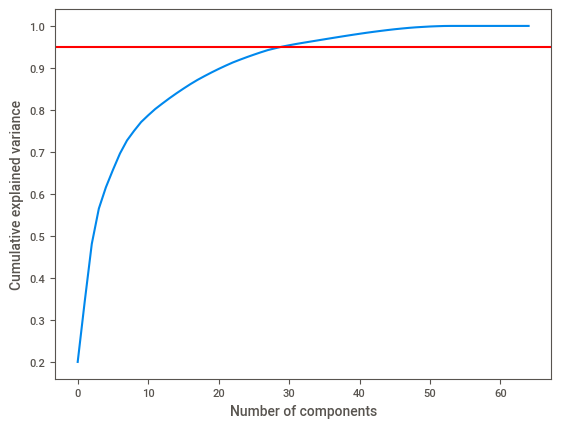

In [57]:
# Generate a cummulative variance ratio chart to determine the number of components to target for PCA.

# Create a copy of the scale_encode_df for processing below
PCA_df = s_e_df.copy()

pca = PCA().fit(PCA_df)
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative_variance_ratio)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.show()

In [59]:
# Using PCA to reduce dimension to the principal components.
pca = PCA(n_components=28)

# Get principal components for the SSS data
sss_pca = pca.fit_transform(PCA_df)
sss_pca

array([[ 0.818679  , -0.44649192, -0.16532687, ..., -0.0044168 ,
         0.01800994, -0.01190643],
       [-0.84398536, -0.30483894,  0.04873332, ..., -0.0172949 ,
        -0.00758893, -0.01559553],
       [-0.84398536, -0.30483894,  0.04873332, ..., -0.0172949 ,
        -0.00758893, -0.01559553],
       ...,
       [ 0.47619178, -0.31072846, -0.71751674, ..., -0.00404248,
         0.03233963,  0.00271828],
       [ 0.47619178, -0.31072846, -0.71751674, ..., -0.00404248,
         0.03233963,  0.00271828],
       [-0.24069927,  0.83201903, -0.19564525, ..., -0.0298672 ,
         0.00975043,  0.01283906]])

In [61]:
# Create a DataFrame with the principal components.
columnz =[]
n_comp=28

for i in range(1,n_comp+1):
    columnz.append('pc'+str(i))

pcs_df = pd.DataFrame(data=sss_pca, columns=columnz, index=encoded_df.index)
pcs_df

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,...,pc19,pc20,pc21,pc22,pc23,pc24,pc25,pc26,pc27,pc28
country,,,,,,,,,,,,,,,,,,,,,
Albania,0.818679,-0.446492,-0.165327,-0.494921,-0.061716,-0.036005,-0.036115,-0.080710,-0.014677,-0.021310,...,-0.004578,-0.023784,-0.019327,-0.021004,-0.013494,-0.009267,0.014049,-0.004417,0.018010,-0.011906
Algeria,-0.843985,-0.304839,0.048733,-0.092380,0.008347,-0.009462,-0.025133,0.043707,-0.063684,-0.035212,...,0.000883,0.016195,0.017768,-0.048959,0.007550,-0.015144,0.004738,-0.017295,-0.007589,-0.015596
Andorra,-0.843985,-0.304839,0.048733,-0.092380,0.008347,-0.009462,-0.025133,0.043707,-0.063684,-0.035212,...,0.000883,0.016195,0.017768,-0.048959,0.007550,-0.015144,0.004738,-0.017295,-0.007589,-0.015596
Angola,0.354965,0.840474,-0.864636,-0.335978,0.235164,0.096168,0.050408,0.431184,0.206190,-0.105737,...,0.282254,0.075056,-0.048752,-0.048688,-0.014077,0.074814,0.021679,0.155408,0.125694,-0.081705
Antigua and Barbuda,-0.843985,-0.304839,0.048733,-0.092380,0.008347,-0.009462,-0.025133,0.043707,-0.063684,-0.035212,...,0.000883,0.016195,0.017768,-0.048959,0.007550,-0.015144,0.004738,-0.017295,-0.007589,-0.015596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Venezuela,1.025620,-0.309089,0.354878,-0.336101,-0.225712,0.177188,0.234476,0.606850,-0.155303,0.048070,...,0.091502,0.114154,-0.062923,-0.026709,-0.004642,-0.297631,-0.106570,-0.319436,-0.161867,0.086167
Vietnam,-0.843985,-0.304839,0.048733,-0.092380,0.008347,-0.009462,-0.025133,0.043707,-0.063684,-0.035212,...,0.000883,0.016195,0.017768,-0.048959,0.007550,-0.015144,0.004738,-0.017295,-0.007589,-0.015596
Yemen,0.476192,-0.310728,-0.717517,0.726758,-0.069391,-0.075631,-0.028656,0.073853,-0.034210,-0.020464,...,0.006668,0.021072,-0.003291,0.011161,0.032913,-0.013858,0.027516,-0.004042,0.032340,0.002718


In [62]:
# Create an elbow curve to find the best value for K.
inertia = []
k= list(range(1,15))

# Create a copy of the scale_encode_df for processing below
KM_P1_df = pcs_df.copy()

# Calculate the inertia for a range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(KM_P1_df)
    inertia.append(km.inertia_)
    
# Create the elbow curve
elbow_data = {'k': k, 'inertia': inertia}
elbow_df = pd.DataFrame(elbow_data)

elbow_df.hvplot(x='k', y='inertia', xticks=k, title='Elbow Curve')

:Curve   [k]   (inertia)

In [63]:
# define the model
KM_P1_model = KMeans(n_clusters=5, random_state=42)

# Fit the model - Make predictions
KM_P1_pred = KM_P1_model.fit_predict(KM_P1_df)

# Add the predicted class columns
KM_P1_df['SSS_class'] = KM_P1_model.labels_

# Concatenate with original df
KM_P1_df= pd.concat([country_df, KM_P1_df], axis=1)

In [64]:
# Generate a sweetviz analysis report
SSS_2_1_report = sv.analyze(KM_P1_df)

SSS_2_1_report.show_html(filepath='SSS_PCA-KMEANS-get_dummies.html', layout='vertical')

                                             |                                             | [  0%]   00:00 ->…

Report SSS_PCA-KMEANS-get_dummies.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [65]:
# define the model
P2_model = DBSCAN(n_jobs=-1)

# Create a copy of the scale_encode_df for processing below
P2_df = pcs_df.copy()

# Fit the model - Make predictions
P2_pred = P2_model.fit_predict(P2_df)

# Add the predicted class columns
P2_df['SSS_class'] = P2_model.labels_

# Concatenate with original df
DP2_df= pd.concat([country_df, P2_df], axis=1)

In [66]:
# Generate a sweetviz analysis report
SSS_2_2_report = sv.analyze(DP2_df)

SSS_2_2_report.show_html(filepath='SSS_PCA-DBSCAN-get_dummies.html', layout='vertical')

                                             |                                             | [  0%]   00:00 ->…

Report SSS_PCA-DBSCAN-get_dummies.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [67]:
# define the model
P3_model = HDBSCAN(n_jobs=-1)

# Create a copy of the scale_encode_df for processing below
P3_df = pcs_df.copy()

# Fit the model - Make predictions
P3_pred = P3_model.fit_predict(P3_df)

# Add the predicted class columns
P3_df['SSS_class'] = P3_model.labels_

# Concatenate with original df
HP3_df= pd.concat([country_df, P3_df], axis=1)

In [68]:
# Generate a sweetviz analysis report
SSS_2_3_report = sv.analyze(HP3_df)

SSS_2_3_report.show_html(filepath='SSS_PCA-HDBSCAN-get_dummies.html', layout='vertical')

                                             |                                             | [  0%]   00:00 ->…

Report SSS_PCA-HDBSCAN-get_dummies.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
